---
# title: "My Notebook"
format:
  html:
    toc: true           # ✅ Table of contents (outline)
    toc-location: left  # ✅ Place TOC in the left sidebar
    number-sections: true
    code-fold: true
    code-summary: "Show Code"
    theme: cosmo        # Optional themes: cosmo, flatly, default, etc.
---

## Traffic Network Analysis using NetworkX
There are two major section. First one is the static road network data processing. Second section is about analyzing the realtime traffic data


Reference
- [Reference of NetworkX](https://networkx.org/documentation/stable/tutorial.html)
- [Source code of NetworkX on GitHub](https://networkx.org/documentation/networkx-2.4/_modules/networkx/readwrite/nx_shp.html)


You may find the networkx versions are different in the terminal and the jupyter notebook. 

In [45]:
import networkx as nx
print(nx.__version__)

3.4.2


It is tricky for the different version of networkx, we are going to use the most recent one. 

In [46]:
# !pip install networkx==3.2.1

This tutorial focuses on spatial networks and learn how to construct a routable directed graph for Networkx and find shortest paths along the given street network based on travel times or distance by car. In addition, we will learn how to calculate travel times from a single source into all nodes in the graph.



In [47]:
import fiona
import os, os.path
import shapely
from shapely.geometry import Polygon, Point, shape
import networkx as nx

#### Create an empty graph

In [48]:
G = nx.Graph()

**Nodes**

The graph `G` can be grown in several ways. NetworkX includes many graph generator functions and facilities to read and write graphs in many formats. To get started though we’ll look at simple manipulations. You can add one node at a time,


In [49]:
G.add_node(1)

or add nodes from any iterable container, such as a list


In [50]:
G.add_nodes_from([2, 3])

add node with attribute

In [51]:
G.add_nodes_from([
    (4, {"color": "red"}),
    (5, {"color": "green"}),
])

We can draw the graph, 

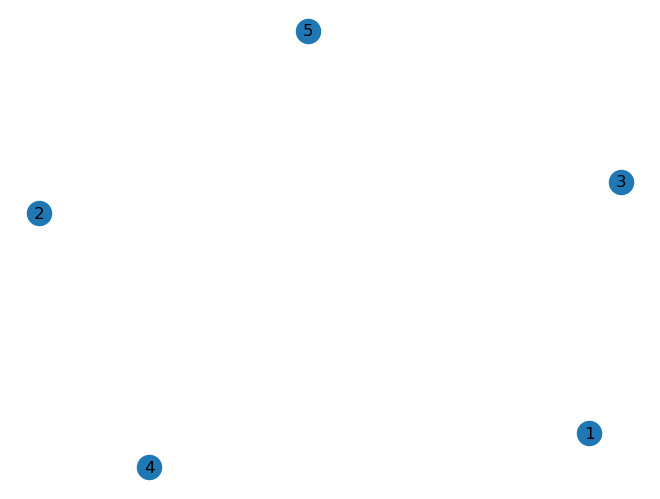

In [52]:
nx.draw(G, with_labels = True)

Print all the nodes of a graph

In [53]:
G.nodes

NodeView((1, 2, 3, 4, 5))

To get the node data along with the nodes:

In [54]:
G.nodes[1], G.nodes[4]

({}, {'color': 'red'})

In [55]:
G.has_node(1)

True

### Edges
We can add edge to the graph

In [56]:
G.add_edge(1, 2)
e = (2, 3)
G.add_edge(*e)  # unpack edge tuple*

In [57]:
G.add_edges_from([(1, 2), (1, 3)])

In [58]:
G.edges

EdgeView([(1, 2), (1, 3), (2, 3)])

Check if the graph has the edge

In [59]:
G.has_edge(*(1,2))

True

In [60]:
G.has_edge(1, 2)

True

In [61]:
G.number_of_nodes()

5

In [62]:
G.number_of_edges()

3

### Examining elements of a graph
We can examine the nodes and edges. Four basic graph properties facilitate reporting: `G.nodes`, `G.edges`, `G.adj` and `G.degree`. These are set-like views of the nodes, edges, neighbors (adjacencies), and degrees of nodes in a graph. They offer a continually updated read-only view into the graph structure. They are also dict-like in that you can look up node and edge data attributes via the views and iterate with data attributes using methods .items(), .data(). If you want a specific container type instead of a view, you can specify one. Here we use lists, though sets, dicts, tuples and other containers may be better in other contexts.

In [63]:
list(G.nodes)

[1, 2, 3, 4, 5]

In [64]:
list(G.edges)


[(1, 2), (1, 3), (2, 3)]

find the adjancent nodes of node 1

In [65]:
list(G.adj[1])  # or list(G.neighbors(1))

[2, 3]

In [66]:
G.degree

DegreeView({1: 2, 2: 2, 3: 2, 4: 0, 5: 0})

In [67]:
# the number of edges incident to 1
G.degree[1]

2

### Edge Attributes

The edge can have different attributes. For example, the road network the edge attribute can be the physical distance. For the social network, the edge attribute can be the relationships. 

In [68]:
G.add_edge(1, 2, weight=4.7 )
G.add_edges_from([(3, 4), (4, 5)], color='red')
G.add_edges_from([(1, 2, {'color': 'blue'}), (2, 3, {'weight': 8})])
G[1][2]['weight'] = 4.7
G.edges[3, 4]['weight'] = 4.2

In [69]:
list(G.edges)

[(1, 2), (1, 3), (2, 3), (3, 4), (4, 5)]

In [70]:
G.edges[3, 4]

{'color': 'red', 'weight': 4.2}

Let's just create some simple graphs and the draw the edges

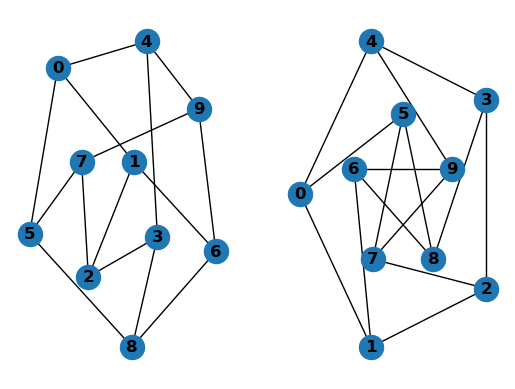

In [71]:
from matplotlib import pyplot as plt

G = nx.petersen_graph()
subax1 = plt.subplot(121)

nx.draw(G, with_labels=True, font_weight='bold')
subax2 = plt.subplot(122)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')


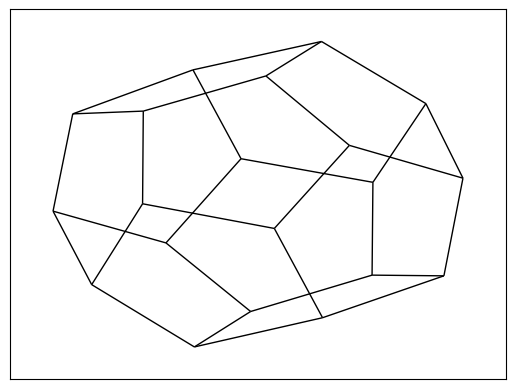

In [72]:
G = nx.dodecahedral_graph()
edges = nx.draw_networkx_edges(G, pos=nx.spring_layout(G))

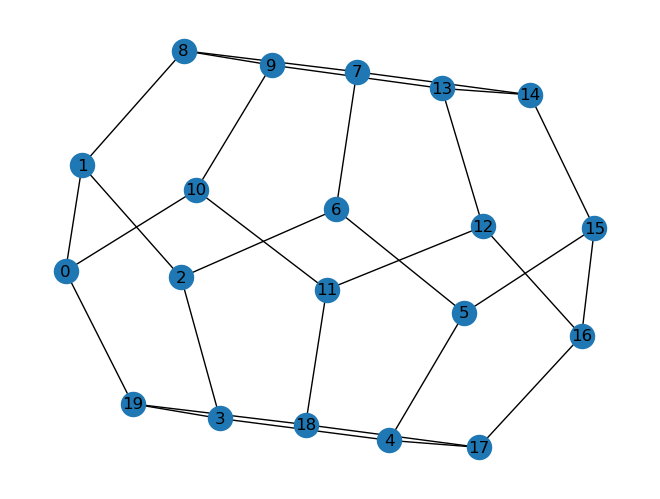

In [73]:

G.add_edge(1, 2)  # default edge data=1
G.add_edge(2, 3)  # specify edge data

nx.draw(G, with_labels = True)


In [75]:
import math
G = nx.Graph()
G.add_edge('y', 'x', function=math.cos)
G.add_node(math.cos)  # any hashable can be a node

In [76]:
elist = [(1, 2), (2, 3), (1, 4), (4, 2)]
G.add_edges_from(elist)
elist = [('a', 'b', 5.0), ('b', 'c', 3.0), ('a', 'c', 1.0), ('c', 'd', 7.3)]
G.add_weighted_edges_from(elist)

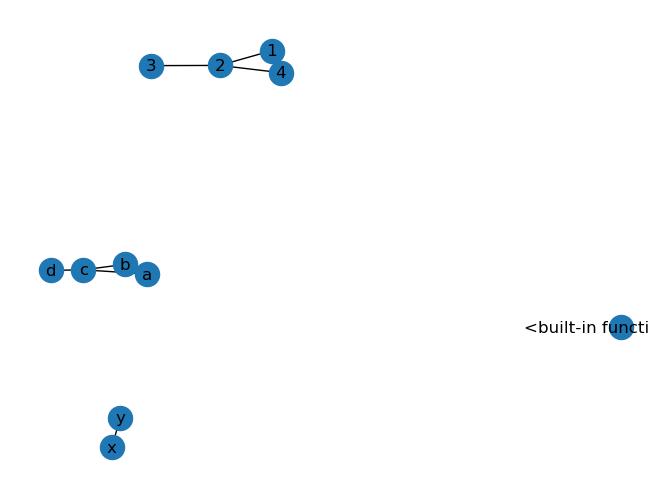

In [77]:
nx.draw(G, with_labels = True)

In [78]:
G = nx.Graph()
e = [('a', 'b', 0.3), ('b', 'c', 0.9), ('a', 'c', 0.5), ('c', 'd', 1.2)]
G.add_weighted_edges_from(e)

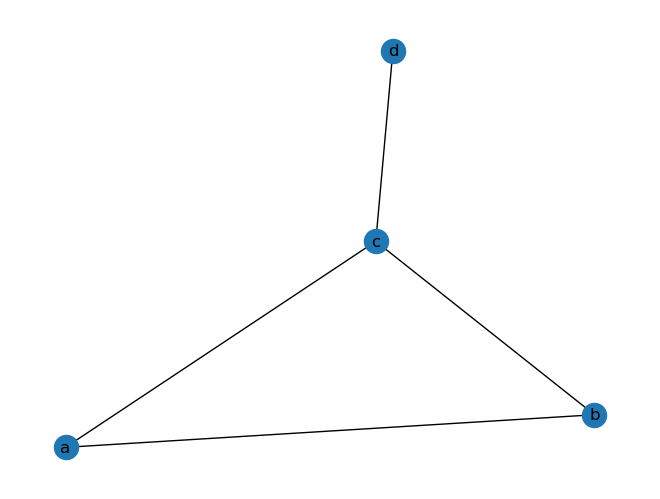

In [79]:
nx.draw(G, with_labels = True)

In [81]:
print(nx.dijkstra_path(G, 'a', 'd'))

['a', 'c', 'd']


### Conduct the network analysis on the road network

#### The following functions are inspired from the sourced code of NetworkX [link](https://networkx.org/documentation/networkx-2.4/_modules/networkx/readwrite/nx_shp.html)

In [82]:
def edges_from_line(geom, attrs, simplify=True, geom_attrs=True):
    """
    Generate edges for each line in geom
    Written as a helper for read_shp

    Parameters
    ----------
    
    geom:  ogr line geometry
        To be converted into an edge or edges
    
    attrs:  dict
        Attributes to be associated with all geoms

    simplify:  bool
        If True, simplify the line as in read_shp

    geom_attrs:  bool
        If True, add geom attributes to edge as in read_shp


    Returns
    -------
     edges:  generator of edges
        each edge is a tuple of form
        (node1_coord, node2_coord, attribute_dict)
        suitable for expanding into a networkx Graph add_edge call
    """
    try:
        from osgeo import ogr
    except ImportError:
        raise ImportError("edges_from_line requires OGR: http://www.gdal.org/")

    if geom.GetGeometryType() == ogr.wkbLineString:
        if simplify:
            edge_attrs = attrs.copy()
            last = geom.GetPointCount() - 1
            if geom_attrs:
                edge_attrs["Wkb"] = geom.ExportToWkb()
                edge_attrs["Wkt"] = geom.ExportToWkt()
                edge_attrs["Json"] = geom.ExportToJson()
            yield (geom.GetPoint_2D(0), geom.GetPoint_2D(last), edge_attrs)
        else:
            for i in range(0, geom.GetPointCount() - 1):
                pt1 = geom.GetPoint_2D(i)
                pt2 = geom.GetPoint_2D(i + 1)
                edge_attrs = attrs.copy()
                if geom_attrs:
                    segment = ogr.Geometry(ogr.wkbLineString)
                    segment.AddPoint_2D(pt1[0], pt1[1])
                    segment.AddPoint_2D(pt2[0], pt2[1])
                    edge_attrs["Wkb"] = segment.ExportToWkb()
                    edge_attrs["Wkt"] = segment.ExportToWkt()
                    edge_attrs["Json"] = segment.ExportToJson()
                    del segment
                yield (pt1, pt2, edge_attrs)

    elif geom.GetGeometryType() == ogr.wkbMultiLineString:
        for i in range(geom.GetGeometryCount()):
            geom_i = geom.GetGeometryRef(i)
            for edge in edges_from_line(geom_i, attrs, simplify, geom_attrs):
                yield edge

In [83]:

def read_shp(path, simplify=True, geom_attrs=True, strict=True):
    """Generates a networkx.DiGraph from shapefiles. Point geometries are
    translated into nodes, lines into edges. Coordinate tuples are used as
    keys. Attributes are preserved, line geometries are simplified into start
    and end coordinates. Accepts a single shapefile or directory of many
    shapefiles.

    "The Esri Shapefile or simply a shapefile is a popular geospatial vector
    data format for geographic information systems software [1]_."

    Parameters
    ----------
    path : file or string
       File, directory, or filename to read.

    simplify:  bool
        If True, simplify line geometries to start and end coordinates.
        If False, and line feature geometry has multiple segments, the
        non-geometric attributes for that feature will be repeated for each
        edge comprising that feature.

    geom_attrs: bool
        If True, include the Wkb, Wkt and Json geometry attributes with
        each edge.

        NOTE:  if these attributes are available, write_shp will use them
        to write the geometry.  If nodes store the underlying coordinates for
        the edge geometry as well (as they do when they are read via
        this method) and they change, your geomety will be out of sync.

    strict: bool
        If True, raise NetworkXError when feature geometry is missing or
        GeometryType is not supported.
        If False, silently ignore missing or unsupported geometry in features.

    Returns
    -------
    G : NetworkX graph

    Raises
    ------
    ImportError
       If ogr module is not available.

    RuntimeError
       If file cannot be open or read.

    NetworkXError
       If strict=True and feature is missing geometry or GeometryType is
       not supported.

    Examples
    --------
    >>> G=nx.read_shp('test.shp') # doctest: +SKIP

    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Shapefile
    """
    try:
        from osgeo import ogr
    except ImportError:
        raise ImportError("read_shp requires OGR: http://www.gdal.org/")

    if not isinstance(path, str):
        return

    net = nx.DiGraph()
    shp = ogr.Open(path)
    if shp is None:
        raise RuntimeError("Unable to open {}".format(path))
    for lyr in shp:
        fields = [x.GetName() for x in lyr.schema]
        for f in lyr:
            g = f.geometry()
            if g is None:
                if strict:
                    raise nx.NetworkXError("Bad data: feature missing geometry")
                else:
                    continue
            flddata = [f.GetField(f.GetFieldIndex(x)) for x in fields]
            attributes = dict(zip(fields, flddata))
            attributes["ShpName"] = lyr.GetName()
            # Note:  Using layer level geometry type
            if g.GetGeometryType() == ogr.wkbPoint:
                net.add_node((g.GetPoint_2D(0)), **attributes)
            elif g.GetGeometryType() in (ogr.wkbLineString,
                                         ogr.wkbMultiLineString):
                for edge in edges_from_line(g, attributes, simplify,
                                            geom_attrs):
                    e1, e2, attr = edge
                    net.add_edge(e1, e2)
                    net[e1][e2].update(attr)
            else:
                if strict:
                    raise nx.NetworkXError("GeometryType {} not supported".
                                           format(g.GetGeometryType()))

    return net


In [84]:
import os, os.path
import fiona
from shapely.geometry import shape


def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)


## Using Networkx2.3 or earlier version
def getNetworkGraph(segments,segmentlengths):
    """
    Builds a networkx graph from the network file, inluding segment length taken from arcpy.
    It selects the largest connected component of the network (to prevent errors from routing between unconnected parts)
    """
    
    import networkx as nx
    
    #generate the full network path for GDAL to be able to read the file
    path = segments # use absolute root
    print (path)
    
    if os.path.exists(path):
        g = read_shp(path)
        
        #This selects the largest connected component of the graph
        #sg = list(nx.connected_component_subgraphs(g.to_undirected()))[0] #before version 2.3
        sg = list(connected_component_subgraphs(g.to_undirected()))[0] ## new version
        
        print ("graph size (excluding unconnected parts): "+str(len(g)))
        
        # Get the length for each road segment and append it as an attribute to the edges in the graph.
        for n0, n1 in sg.edges():
            oid = sg[n0][n1]["objectid"] #osm_id
            sg[n0][n1]['length'] = segmentlengths[oid]
            sg[n0][n1]['fid'] = oid
#             print(sg)
        return sg
    else:
        print ("network file not found on path: "+path)


def getSegmentInfo(segments):
    """
    Builds a dictionary for looking up endpoints of network segments (needed only
    because networkx graph identifies edges by nodes)
    """
    
    # import os, os.path
    # import fiona
    # from shapely.geometry import shape, mapping
    
    if os.path.exists(segments):
        endpoints = {}
        segmentlengths = {}
        street_lyr = fiona.open(streetMap, 'r')
        
        for idx, feat in enumerate(street_lyr):
            geom = feat['geometry']
            coord = geom['coordinates']
            feat_id = feat['properties']['objectid'] #osm_id
            length = shape(geom).length
            
            if idx % 10000 == 0: print('The osmid and length are:', idx, feat_id, length)
            
            # first point and the last point
            endpoints[feat_id] = ((coord[0][0], coord[0][1]), (coord[-1][0], coord[-1][1]))
            segmentlengths[feat_id] = length
            
        print ("Number of segments: "+ str(len(endpoints)))
        return (endpoints, segmentlengths)
    else:
        print ("segment file does not exist!")


def buildNetwork(segments):
    #build network graph (graph, endpoints, lengths) and get segment info
    r = getSegmentInfo(segments)
    endpoints = r[0]
    lengths = r[1]
    graph = getNetworkGraph(segments,lengths)
    
    return [endpoints, lengths, graph]

We can create the graph from the shapefile. You can download the sidewalk shapefile from [here](data/sidewalk.zip). 

In [ ]:
streetMap = 'data/sidewalk.shp'

[endpoints, lengths, graph] = buildNetwork(streetMap)

Here we use two endpoints of the sidewalk graph as the origin and destination.

In [40]:
s1_point = (2674629.019778946, 233887.42317315526)
s2_point = (2676819.994840707, 233998.8937345071)

#Compute a shortest path (using segment length) on graph where segment endpoints are nodes and segments are (undirected) edges
if graph.has_node(s1_point) and graph.has_node(s2_point):
    dist = nx.shortest_path_length(graph, s1_point, s2_point, weight='length')
    path = nx.shortest_path(graph, s1_point, s2_point, weight='length')

In [85]:
dist, path

(2239.187257781493,
 [(2674629.019778946, 233887.42317315526),
  (2675063.484593347, 233895.2384052628),
  (2675115.2077349196, 233892.43677666123),
  (2675131.3505460056, 233892.1815988601),
  (2675157.64553571, 233891.76624855347),
  (2675194.6822983907, 233894.80562187612),
  (2675558.573598633, 233899.59502712416),
  (2675613.0183556173, 233905.90717337467),
  (2675630.2018974577, 233911.72542009607),
  (2675651.2510666423, 233903.49926487225),
  (2675728.5513929822, 233904.42103680802),
  (2675735.165564337, 233913.50363536438),
  (2675973.666402716, 233913.2098672439),
  (2676051.848300272, 233914.85865282876),
  (2676233.1438519773, 233925.74859682945),
  (2676240.7664461, 233911.12548257585),
  (2676257.4528208617, 233898.6908843843),
  (2676265.9243400875, 233894.33221573415),
  (2676308.2581279846, 233915.78094614836),
  (2676310.4227480562, 233924.97806112084),
  (2676809.520503303, 234003.31260332352),
  (2676819.994840707, 233998.8937345071)])

#### Get the shortest distance and also the path of the shortest distance

In [86]:
#Compute a shortest path (using segment length) on graph where segment endpoints are nodes and segments are (undirected) edges
if graph.has_node(s1_point) and graph.has_node(s2_point):
    dist = nx.shortest_path_length(graph, s1_point, s2_point, weight='length')
    path = nx.shortest_path(graph, s1_point, s2_point, weight='length')
    #get path edges
    path_edges = zip(path,path[1:])
    #print "edges: "+str(path_edges)
    subpath = []
    # get object ids for path edges
    for e in path_edges:
        oid = graph[e[0]][e[1]]["objectid"]
        subpath.append(oid)
    print ("oid path:"+str(subpath))

oid path:[67, 101354, 153614, 136348, 99194, 119948, 83281, 112093, 158108, 91137, 180777, 175219, 80366, 179855, 155287, 99997, 115588, 75881, 177392, 125590, 163167]


In [87]:
for idx, node in enumerate(graph.nodes):
    if idx >10: continue
    print(node)

(2674629.019778946, 233887.42317315526)
(2675063.484593347, 233895.2384052628)
(2677370.9139951007, 234099.03786372015)
(2677331.098267104, 234139.85190359864)
(2676819.994840707, 233998.8937345071)
(2676874.8400247567, 234004.04994090827)
(2677398.8984584543, 234090.96045311925)
(2677452.6642256537, 234098.92121608992)
(2677418.0230016173, 234179.81781638178)
(2677382.3291674173, 234191.45753613432)
(2676893.9161705, 233916.11122627818)


In [89]:
s1_point = (2675063.484593347, 233895.2384052628)
s2_point = (2688743.6504137763, 232314.04444539145)

In [88]:
graph.has_node(s1_point)

True

In [90]:
graph.has_node(s2_point)

True

In [91]:
dist = nx.shortest_path_length(graph, s1_point, s2_point, weight='length')
path = nx.shortest_path(graph, s1_point, s2_point, weight='length')

In [92]:
dist

16415.891881111354

In [55]:
path

[(2675063.484593347, 233895.2384052628),
 (2675115.2077349196, 233892.43677666123),
 (2675131.3505460056, 233892.1815988601),
 (2675157.64553571, 233891.76624855347),
 (2675194.6822983907, 233894.80562187612),
 (2675558.573598633, 233899.59502712416),
 (2675613.0183556173, 233905.90717337467),
 (2675630.2018974577, 233911.72542009607),
 (2675651.2510666423, 233903.49926487225),
 (2675728.5513929822, 233904.42103680802),
 (2675735.165564337, 233913.50363536438),
 (2675973.666402716, 233913.2098672439),
 (2676051.848300272, 233914.85865282876),
 (2676233.1438519773, 233925.74859682945),
 (2676240.7664461, 233911.12548257585),
 (2676257.4528208617, 233898.6908843843),
 (2676265.9243400875, 233894.33221573415),
 (2676308.2581279846, 233915.78094614836),
 (2676310.4227480562, 233924.97806112084),
 (2676809.520503303, 234003.31260332352),
 (2676819.994840707, 233998.8937345071),
 (2676874.8400247567, 234004.04994090827),
 (2676874.064745394, 234014.15348545252),
 (2676957.813333418, 234023.4

### create the shapefile based on the path

We have the path, we can create the shapefile based on the path.

In [95]:
layer = fiona.open(streetMap)
crs = layer.crs
# schema = layer.schema

In [96]:
schema = {'properties': {
                        'fid': 'str'
                        },
         'geometry': 'LineString'
         }

In [59]:
from shapely.geometry import shape, mapping
from shapely.geometry import LineString, Point

with fiona.open('outname.shp', 'w', crs = crs, driver='ESRI Shapefile', schema = schema) as out:
    for i in range(len(path) - 1):
        node1 = path[i]
        node2 = path[i+1]
        
        line = LineString((Point(node1), Point(node2)))
        
        feat = {
                'geometry': mapping(line), 
               'properties': 
                        {'fid': i}
               }
        out.write(feat)


#### Find the nearest node of any input point

You may wonder, what if the origin and destination node are not in the graph. How do we calculate the shortest distance and find the shortest path? We can snap those points to the nearest nodes in the graph. The following scripts can help you find the nearest node of any input point.

we can loop and see all the ndoes

In [60]:
for idx, node in enumerate(graph.nodes):
    if idx >10: continue
    print(node)

(2674629.019778946, 233887.42317315526)
(2675063.484593347, 233895.2384052628)
(2677370.9139951007, 234099.03786372015)
(2677331.098267104, 234139.85190359864)
(2676819.994840707, 233998.8937345071)
(2676874.8400247567, 234004.04994090827)
(2677398.8984584543, 234090.96045311925)
(2677452.6642256537, 234098.92121608992)
(2677418.0230016173, 234179.81781638178)
(2677382.3291674173, 234191.45753613432)
(2676893.9161705, 233916.11122627818)


Numpy is very efficient for indexing and computing, we going to turn the coordinates of nodes into numpy arrays.

In [97]:
import numpy as np

nodelist = list(graph.nodes)
node_array = np.array(nodelist)

In [98]:
node_array.shape

(88516, 2)

In [99]:
node_array[0,:]

array([2674629.01977895,  233887.42317316])

Specify any point with x, and y in the study area

In [100]:
anypnt = (2675067.484593347, 233893.2384052628)

calculate the absolute difference of the anypoint to all the nodes in the graph

In [101]:
abs_diff = np.abs(anypnt - node_array)

In [102]:
abs_diff.shape

(88516, 2)

we will sum the x, and y for each node.

In [103]:
abs_diff_sum = np.sum(abs_diff, 1)
abs_diff_sum.shape

(88516,)

we can easily find the index of the minimum value

In [104]:
index = abs_diff_sum.argmin()
index

1

we can find the coordinate of the nearest node

In [105]:
nodelist[1]

(2675063.484593347, 233895.2384052628)

In [106]:
anypnt

(2675067.484593347, 233893.2384052628)